### Plot Geodata

If you wanna load new data from open street map you need to install the osmnx package. Otherwise the geopandas package suffices.


### To run the omsnx module in this notebook please do:


#### Use conda to build Python env with osmnx as main so that not upto date version in dependancies used but workable for osmnx

conda config --prepend channels conda-forge

conda create -n ox --strict-channel-priority osmnx

#### go into env
conda activate ox

#### install other libs that are needed for visulization
conda install matplotlib
conda install numpy
conda install -c anaconda ipykernel

#### makes conda env into a kernel which then can be used by jupyter notebook
python -m ipykernel install --user --name=ox

#### other Tool for queries to OpenStreetMap in testing phase
pip install OSMPythonTools


In [1]:
from virusPropagationModel import *
import glob
import osmnx as ox # not required for plotting only 
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.cm as cm 
%matplotlib inline



In [2]:
mainModelCmap = cm.get_cmap('Set1')  # for our statuses and flags
statusAndFlagsColors = {
    'I': mainModelCmap(0),  # red
    'S': mainModelCmap(1),  # blue
    'R': mainModelCmap(2),  # green
    'D': 'black',

    'IsInfected': mainModelCmap(0),  # red
    'WasInfected': mainModelCmap(0),  # red
    'WasDiagnosed': mainModelCmap(4),  # blue
    'Diagnosed': mainModelCmap(4),  # orange
    'Hospitalized': mainModelCmap(6),  # brown
    'WasHospitalized': mainModelCmap(6),
    'WasICUed': mainModelCmap(7),
    'ICUed': mainModelCmap(7),  # pink
}


locationsCmap1 = cm.get_cmap('Dark2')  # for our locations
locationsCmap2 = cm.get_cmap('tab20')
locationTypeColors = {
    'home': locationsCmap1(0),  # aquamarine
    'public': locationsCmap1(2),  # purple-blue
    'work': locationsCmap1(3),  # deep pink
    'hospital': locationsCmap1(5),  # mustard yellow
    'school': locationsCmap2(17),  # olive green - khaki
    'morgue': locationsCmap1(7)  # gray
}

### Load simulation and simulate

In [3]:
#sim_name = 'no_mitigation_inf_0.5_0'
world_name = 'Gangelt_MA_1_1'

#Simulation = load_simulation_object(sim_name, folder='server_data/')
world = load_simulation_object(world_name, folder='server_data/')
#Simulation.simulate()
    
    
    

Text(0, 0.5, 'Number of Locations')

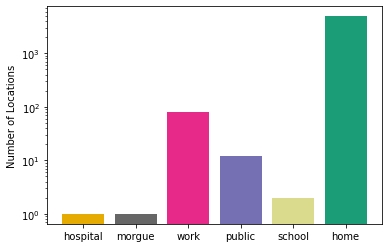

In [4]:
world.plot_distribution_of_location_types()
ax = plt.gca()
ax.set_yscale('log')
ax.set_ylabel('Number of Locations')
#plt.savefig('distribution_of_location_types', dpi=600)

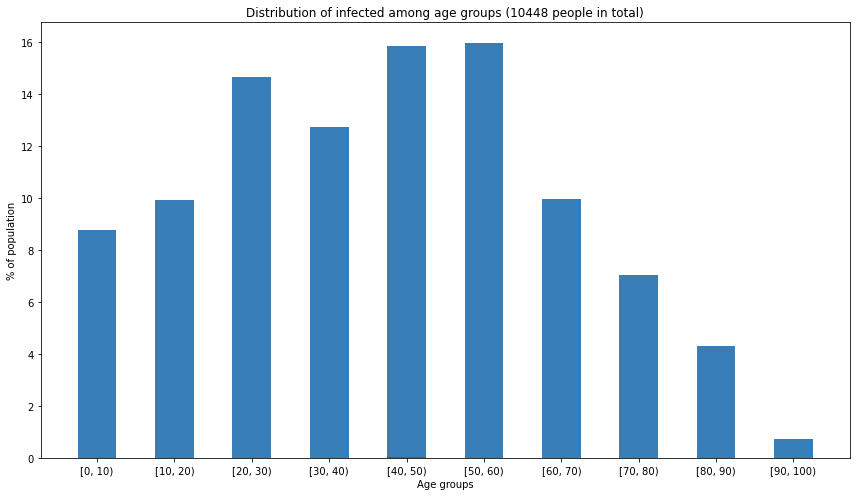

In [6]:
world.initialize_infection(specific_people_ids=[i for i in range(5)])

world.plot_initial_distribution_of_ages_and_infected(age_groups_step=10, save_figure=True)


#fig = plt.gcf()
#ax.savefig('distribution_of_ages_and_infected.png', dpi=600)

In [97]:
ax.set_yscale('log')

In [6]:
df_loc_stat = Simulation.get_location_and_status()

In [7]:
df_loc_stat[df_loc_stat['time']==1]

status,loc,time,D,I,R,S,x_coordinate,y_coordinate,location_type
1,0,1,0.0,3.0,0.0,0.0,5.988614,50.994357,home
1467,1,1,0.0,1.0,0.0,2.0,5.986677,50.994739,home
3029,2,1,0.0,0.0,0.0,1.0,5.987261,50.994082,home
4363,3,1,0.0,0.0,0.0,6.0,5.985595,50.994177,home
5805,4,1,0.0,0.0,0.0,1.0,5.985645,50.993582,home
...,...,...,...,...,...,...,...,...,...
7570762,5014,1,0.0,0.0,0.0,4.0,5.993722,50.996466,home
7572416,5015,1,0.0,0.0,0.0,3.0,5.993688,50.996660,home
7573939,5016,1,0.0,0.0,0.0,2.0,6.049444,51.007805,home
7575438,5017,1,0.0,0.0,0.0,2.0,6.040157,50.980532,home


### map status 

Text(5.961319457002723, 50.95456235, 'M')

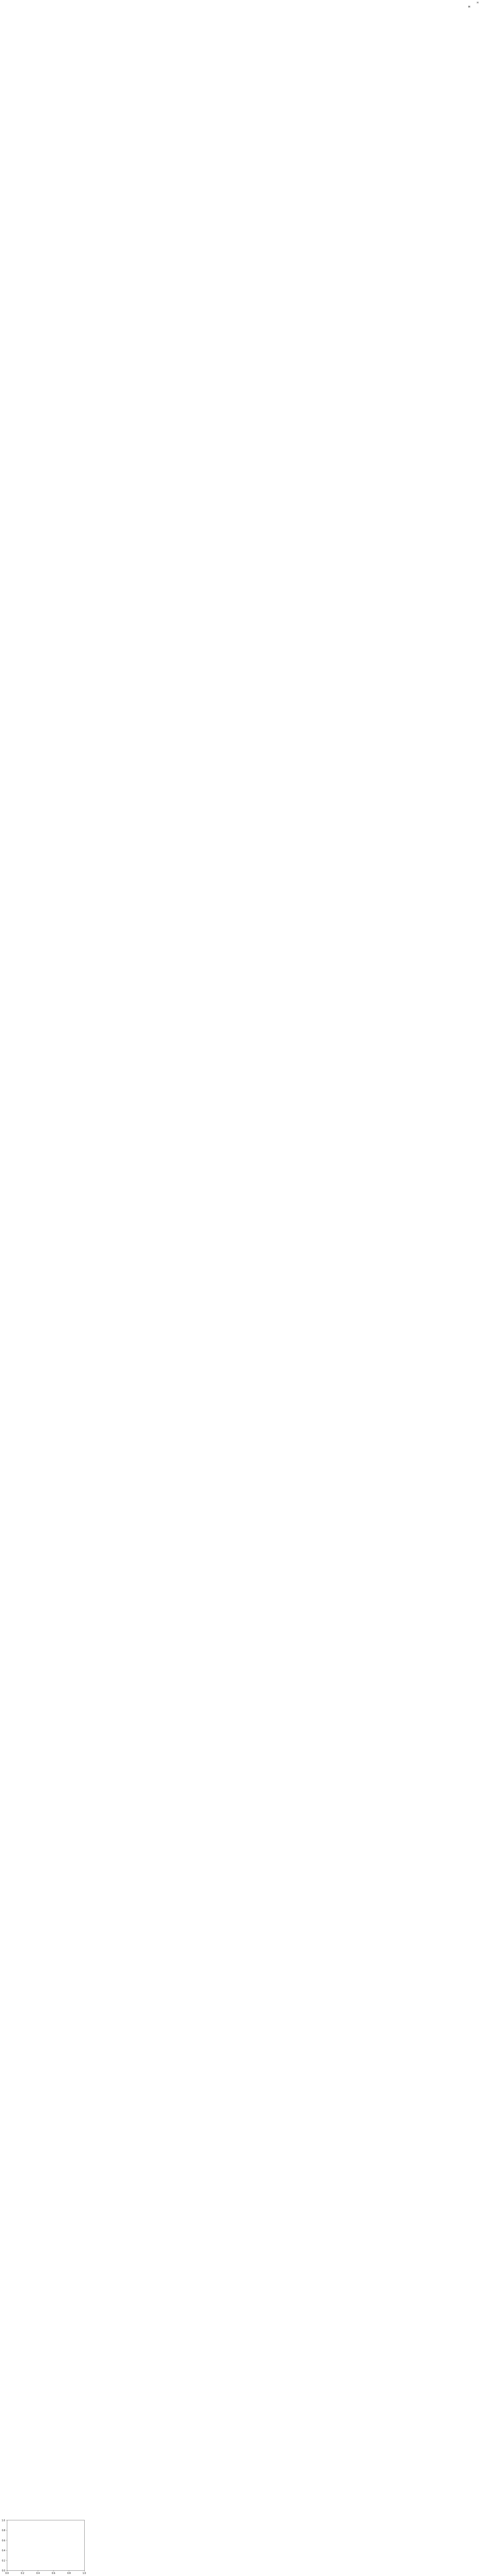

In [43]:
plt.text(max(buildings['building_coordinates_x']),max(buildings['building_coordinates_y']), 'H')
plt.text(min(buildings['building_coordinates_x']),min(buildings['building_coordinates_y']),'M')


In [21]:
steps = Simulation.time_steps
#steps = 1
#stats= ['I','R','S','D']
stats= ['I']#,'R','S','D']

#cmap2 = cm.get_cmap('Set1')
#statusAndFlagsColors[stat]

for i,stat in enumerate(stats):
    for time in range(steps):
            #stat='I'
            loc_stat_t = df_loc_stat[df_loc_stat['time']==time]

            plt.figure(figsize=(15,7))
            ax = plt.subplot()
            #cmap = cm.get_cmap('Dark2')
            area.plot(ax=ax, color='k' ,alpha=0.01)
            streets.plot(ax=ax, color='k', alpha=0.1)
            buildings.plot(ax=ax, color='gray')#cmap='Dark2')

            ax.scatter(loc_stat_t['x_coordinate'],loc_stat_t['y_coordinate'], s = 20*loc_stat_t[stat], alpha=0.5, label=stat, color=statusAndFlagsColors[stat])
            plt.text(max(buildings['building_coordinates_x']),max(buildings['building_coordinates_y']), 'H')
            plt.text(min(buildings['building_coordinates_x']),min(buildings['building_coordinates_y']), 'M')
            #for k,stat in enumerate(['R','S','I','D']):
                #plt.subplot(2,2,k+1)
                #plt.title(stat)
                #plt.scatter(loc_stat_t['x_coordinate'],loc_stat_t['y_coordinate'], s = 20*loc_stat_t[stat], alpha=0.3, label=stat, color=cmap(k))
            #plt.suptitle('status at time '+str(time))
            plt.title(str(stat)+' in Gangelt at '+str(time)+' h')
            plt.tight_layout()
            #plt.legend()
            plt.savefig('plots/no_mitigation/loc_t_'+str(stat)+'_'+sim_name+'_'+str(time)+'.png')
            plt.close()

#for k,p in enumerate(list_of_neighbourhood_centers):
#    ax.scatter(p.x,p.y, color = cmap(k), s=400, alpha=0.5, label=k)
#ax.legend(title='neighbourhood', frameon=False)    


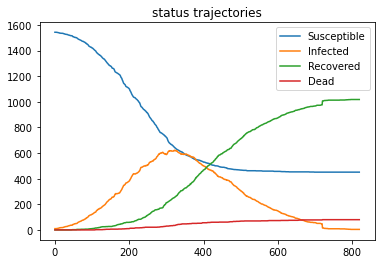

In [6]:
Simulation.plot_status_timecourse()

plt.plot()

#### How to load geodata from Openstreetmap (takes long)

In [10]:
# Specify the name that is used to seach for the data
#place_name = "Heinsberg, Nordrhein-Westfalen, Germany"
place_name = "Gangelt, Kreis Heinsberg, Nordrhein-Westfalen, Germany"

# Fetch OSM street network from the location, only once! takes forever  
graph = ox.graph_from_place(place_name)
area = ox.gdf_from_place(place_name)
buildings = ox.footprints_from_place(place_name)


#### Load our (reduced) dataset
(if not present in the datafiles folder pls run: python read_geodata.py -ma 1)

In [29]:
min_area = 1 # [1,3] 

area = gpd.read_file('datafiles/Area_Gangelt_MA_'+str(min_area)+'.geojson')
buildings = gpd.read_file('datafiles/Buildings_Gangelt_MA_'+str(min_area)+'.geojson')
streets = gpd.read_file('datafiles/Streets_Gangelt_MA_'+str(min_area)+'.geojson')

#### center of neihbourhood is choosen manually 

In [10]:
list_of_neighbourhood_centers = [Point(5.99,51.03),Point(6.04,50.98),Point(6.05,51.01),Point(5.99,50.99)]

#### plot location

Text(0.5, 1.0, 'Gangelt')

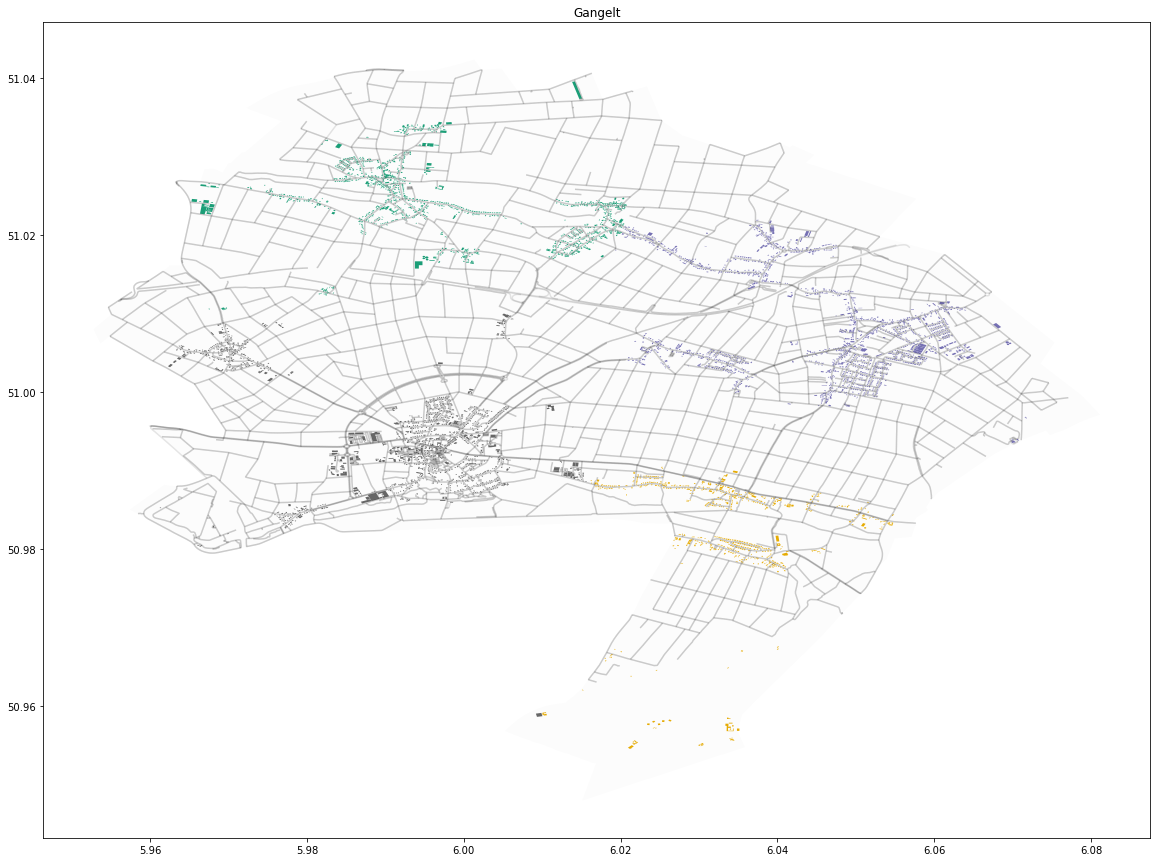

In [12]:
#r1 = gpd.read_file('datafiles/Buildings_Heinsberg.geojson')
import matplotlib.cm as cm 

fig, ax = plt.subplots(figsize=(20,15))
ax = plt.subplot()
cmap = cm.get_cmap('Dark2')

area.plot(ax=ax, color='k' ,alpha=0.01)
streets.plot(ax=ax, color='k', alpha=0.1)
buildings.plot(ax=ax, column='neighbourhood', cmap='Dark2')

#for k,p in enumerate(list_of_neighbourhood_centers):
#    ax.scatter(p.x,p.y, color = cmap(k), s=400, alpha=0.5, label=k)
#ax.legend(title='neighbourhood', frameon=False)    
plt.title(str(time)+' time ')


### zoomed to neighbourhood 

(51.0, 51.06)

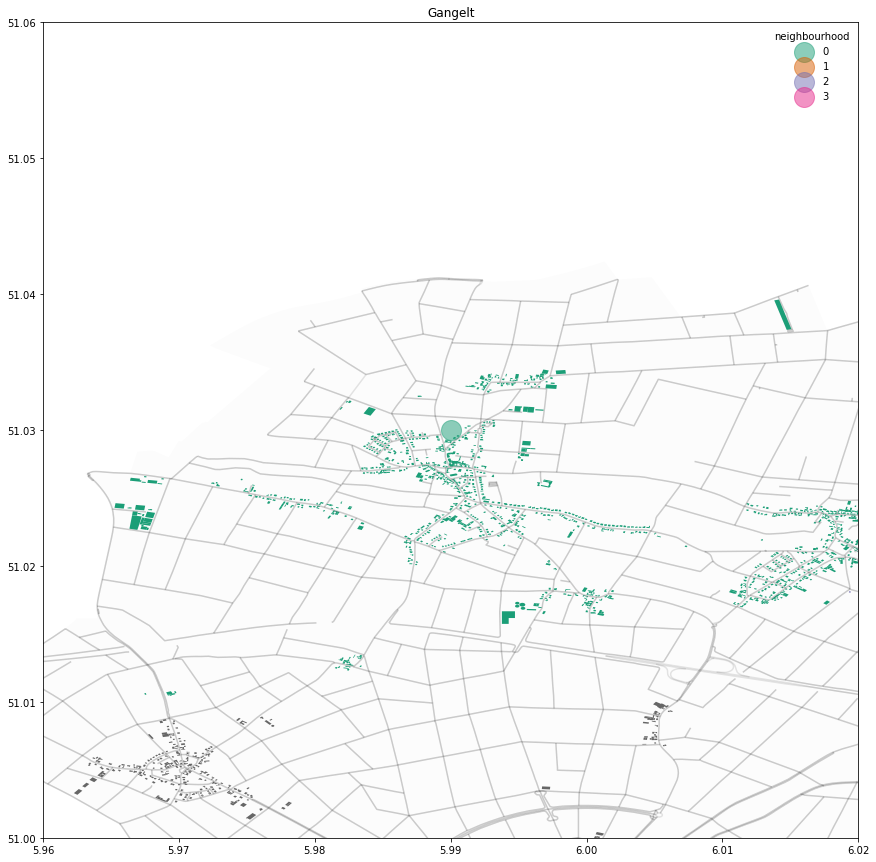

In [6]:
plotrange=0.03
neighbourhood = 0

fig, ax = plt.subplots(figsize=(20,15))
ax = plt.subplot()
cmap = cm.get_cmap('Dark2')

area.plot(ax=ax, color='k' ,alpha=0.01)
streets.plot(ax=ax, color='k', alpha=0.1)
buildings.plot(ax=ax, column='neighbourhood', cmap='Dark2')

for k,p in enumerate(list_of_neighbourhood_centers):
    ax.scatter(p.x,p.y, color = cmap(k), s=400, alpha=0.5, label=k)
ax.legend(title='neighbourhood', frameon=False)    
plt.title('Gangelt')
ax.set_xlim(list_of_neighbourhood_centers[neighbourhood].x-plotrange,list_of_neighbourhood_centers[neighbourhood].x+plotrange)
ax.set_ylim(list_of_neighbourhood_centers[neighbourhood].y-plotrange,list_of_neighbourhood_centers[neighbourhood].y+plotrange)

#### plot infection status

#### plot location type

### list of 'amenities'

In [7]:
print(buildings['amenity'].unique())

[None 'restaurant' 'townhall' 'place_of_worship' 'cafe' 'kindergarten'
 'pub' 'doctors' 'fire_station' 'pharmacy' 'dentist'
 'animal_physiotherapy' 'trailer_parking' 'social_facility']


### List of all relevant columns and their unique values for building type assignment

In [8]:
col_names=['building','amenity','shop','leisure', 'sport', 'office','healthcare']

for x in col_names:
    print(x)
    try:
        print(buildings[x].dropna().unique())
    except:
        print('column not in DataFrame')
    print('\n')

building
['retail' 'yes' 'civic' 'farm' 'church' 'apartments' '28'
 'semidetached_house' 'greenhouse' '8' '23' 'commercial' 'house'
 'bungalow' 'detached' 'office' 'industrial' 'silo' 'barn' 'roof' 'chapel'
 'hangar' '36' 'residential' 'shed' 'garage']


amenity
['restaurant' 'townhall' 'place_of_worship' 'cafe' 'kindergarten' 'pub'
 'doctors' 'fire_station' 'pharmacy' 'dentist' 'animal_physiotherapy'
 'trailer_parking' 'social_facility']


shop
['bicycle' 'funeral_directors' 'clothes']


leisure
['sports_centre' 'pitch']


sport
['multi' 'equestrian']


office
column not in DataFrame


healthcare
['doctor' 'dentist']




In [28]:
buildings['neighbourhood'].unique()

,building,amenity,shop,leisure,sport,healthcare,healthcare:speciality,building:levels,building_coordinates_x,building_coordinates_y,building_area,neighbourhood,geometry,building_type
0,retail,None,None,None,None,None,None,1,5.988614,50.994357,7.679213e-07,3,"POLYGON ((5.98808 50.99472, 5.98822 50.99427, ...",home
1,retail,None,None,None,None,None,None,None,5.986677,50.994739,2.035797e-07,3,"POLYGON ((5.98614 50.99482, 5.98615 50.99463, ...",home
2,retail,None,None,None,None,None,None,1,5.987261,50.994082,1.906354e-07,3,"POLYGON ((5.98700 50.99433, 5.98701 50.99429, ...",home
3,retail,None,None,None,None,None,None,None,5.985595,50.994177,8.218644e-08,3,"POLYGON ((5.98529 50.99421, 5.98533 50.99407, ...",home
4,retail,None,None,None,None,None,None,1,5.985645,50.993582,1.336616e-07,3,"POLYGON ((5.98543 50.99377, 5.98553 50.99345, ...",home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,yes,None,None,None,None,None,None,None,5.993722,50.996466,2.089274e-08,3,"POLYGON ((5.99364 50.99653, 5.99379 50.99654, ...",home
5015,yes,None,None,None,None,None,None,None,5.993688,50.996660,1.407490e-08,3,"POLYGON ((5.99361 50.99671, 5.99375 50.99671, ...",home
5016,yes,None,None,None,None,None,None,None,6.049444,51.007805,1.047291e-07,1,"POLYGON ((6.04949 51.00791, 6.04956 51.00791, ...",home
5017,yes,None,None,None,None,None,None,None,6.040157,50.980532,1.148881e-07,2,"POLYGON ((6.04017 50.98070, 6.04019 50.98070, ...",home


### Same building classification functions as in the project

In [35]:


def assign_location_classifier(df_buildings):
        '''Build reference lists for assign_building_type() from given dataframe.
        Should be produced by read_geodata.py.
        Possible classes and therefore dictionary keys are:
        'excluded_buildings' = buildings not included because they do not fit any class
        'hospital' = hospitals
        'work' = anything a person can work at
        'public' = right now religous and sport buildings #FIXME-Discussion: restaurantes, bars, cafe?
        'school' = places with a lot of young people
        Sorting idea as of right now everything is work place if not in any other list
        : return: location class dictionary loc_class_dic['school'] = ['school','university','kindergarten']

        '''
        loc_class_dic = {}

        loc_class_dic['excluded_buildings'] = ['garage', 'roof', 'shed', 'bungalow', 'barn', 'silo']
        loc_class_dic['hospital'] = ['hospital']
        loc_class_dic['morgue'] = ['morgue']

        loc_class_dic['work'] = ['industrial', 'greenhouse', 'cowshed', 'shed', 'commercial', 'warehouse', 'office', 'farm']\
            + list(df_buildings['amenity'].unique())\
            + list(df_buildings['shop'].unique())

        # What is a public place or just work place e.g. restaurante, cafe...

        loc_class_dic['public'] = ['public', 'chapel', 'church']\
            + list(df_buildings['leisure'].unique())\
            + list(df_buildings['sport'].unique())

        loc_class_dic['school'] = ['school', 'university', 'kindergarten']
        # Cleaning the list public place of nan
        loc_class_dic['public'] = [x for x in loc_class_dic['public'] if ~pd.isnull(x)]
        # Removing values from workplace_list that are in work place and in another list
        for x in loc_class_dic['hospital'] + [np.nan] + loc_class_dic['public'] + loc_class_dic['school']:
            while x in loc_class_dic['work']:
                loc_class_dic['work'].remove(x)

        return loc_class_dic    

def assign_building_type(building_lst:list, loc_class_dic):
        '''set building type according to value in building_lst and where it matches with reference lists

            : return: string with building type
        '''
        #auto assign is home
        building_type = 'home'
        #if any entry of building_lst matches any location class entry: it is assigned to that class
        for key in loc_class_dic:
            if any(elem in loc_class_dic[key] for elem in building_lst):
                building_type = key
        
        return building_type

### Classification process

In [32]:
buildings

,building,amenity,shop,leisure,sport,healthcare,healthcare:speciality,building:levels,building_coordinates_x,building_coordinates_y,building_area,neighbourhood,geometry
0,retail,None,None,None,None,None,None,1,5.988614,50.994357,7.679213e-07,3,"POLYGON ((5.98808 50.99472, 5.98822 50.99427, ..."
1,retail,None,None,None,None,None,None,None,5.986677,50.994739,2.035797e-07,3,"POLYGON ((5.98614 50.99482, 5.98615 50.99463, ..."
2,retail,None,None,None,None,None,None,1,5.987261,50.994082,1.906354e-07,3,"POLYGON ((5.98700 50.99433, 5.98701 50.99429, ..."
3,retail,None,None,None,None,None,None,None,5.985595,50.994177,8.218644e-08,3,"POLYGON ((5.98529 50.99421, 5.98533 50.99407, ..."
4,retail,None,None,None,None,None,None,1,5.985645,50.993582,1.336616e-07,3,"POLYGON ((5.98543 50.99377, 5.98553 50.99345, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,yes,None,None,None,None,None,None,None,5.993722,50.996466,2.089274e-08,3,"POLYGON ((5.99364 50.99653, 5.99379 50.99654, ..."
5015,yes,None,None,None,None,None,None,None,5.993688,50.996660,1.407490e-08,3,"POLYGON ((5.99361 50.99671, 5.99375 50.99671, ..."
5016,yes,None,None,None,None,None,None,None,6.049444,51.007805,1.047291e-07,1,"POLYGON ((6.04949 51.00791, 6.04956 51.00791, ..."
5017,yes,None,None,None,None,None,None,None,6.040157,50.980532,1.148881e-07,2,"POLYGON ((6.04017 50.98070, 6.04019 50.98070, ..."


In [36]:
buildings = gpd.read_file('datafiles/Buildings_Gangelt_MA_'+str(min_area)+'.geojson')
loc_class_dic = assign_location_classifier(buildings)
#Columns important to classify building type and therefore which location type it is
col_names = ['building','amenity','shop','leisure', 'sport','healthcare']
#start of boolcheck to see if at least one hospital in dataframe
buildings['building_type']= buildings.apply(lambda row: assign_building_type(row[col_names].dropna().unique(), loc_class_dic), axis = 1) 

### Plot coloring the buildings by classification

/opt/anaconda3/envs/ox/lib/python3.8/site-packages/geopandas/plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/anaconda3/envs/ox/lib/python3.8/site-packages/geopandas/plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
No handles with labels found to put in legend.


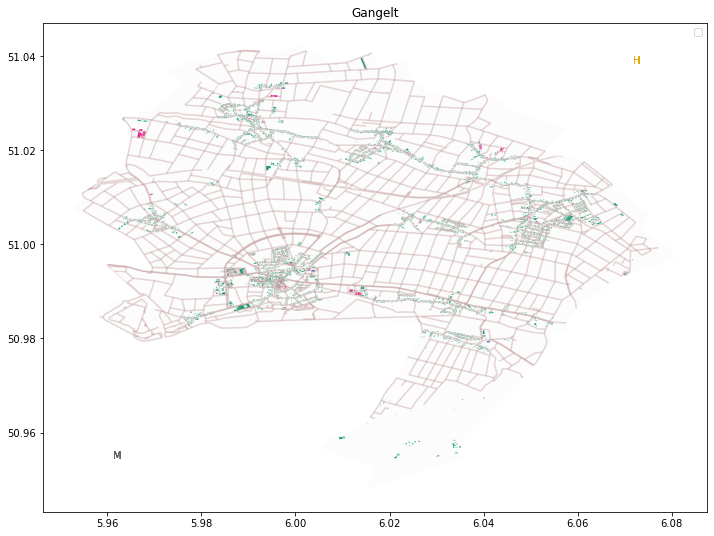

In [91]:
plotrange=0.02
neighbourhood = 3
print()
import matplotlib.cm as cm 

fig, ax = plt.subplots(figsize=(12,9))
ax = plt.subplot()
cmap = cm.get_cmap('Dark2')

area.plot(ax=ax, color='black' ,alpha=0.01)
streets.plot(ax=ax, color='#BC8F8F', alpha=0.2)

for building_type in locationTypeColors:
    buildings[buildings['building_type']==building_type].plot(ax=ax, color=locationTypeColors[building_type], label=building_type, legend=False,legend_kwds={'frameon':False, 'loc':'lower right'})
    ax.text(max(buildings['building_coordinates_x']),max(buildings['building_coordinates_y']), 'H', c=locationsCmap1(5))
    ax.text(min(buildings['building_coordinates_x']),min(buildings['building_coordinates_y']), 'M', c=locationsCmap1(7))
    ax.set_label('s')
    #handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles=[building_type], loc='lower right')
plt.legend()
plt.title('Gangelt')
plt.savefig('gangelt_location_type_map.png', dpi=600)
#plt.legend()    
#ax.set_xlim(list_of_neighbourhood_centers[neighbourhood].x-plotrange,list_of_neighbourhood_centers[neighbourhood].x+plotrange)
#ax.set_ylim(list_of_neighbourhood_centers[neighbourhood].y-plotrange,list_of_neighbourhood_centers[neighbourhood].y+plotrange)

In [81]:
ax.get_legend_handles_labels()
ax.set_label()

([], [])

In [13]:
#### number of locations

In [14]:
len(buildings)

5019

### voronoi prob

not implemented idea to assign neighbourhoods 

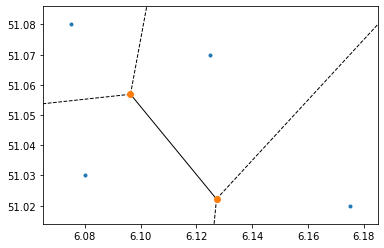

In [15]:
from scipy.spatial import Voronoi, voronoi_plot_2d
points = np.random.random((10, 2))

points =np.array([[6.080,51.03],
                   [6.175,51.02],
                   [6.075,51.08],
                   [6.125,51.07]])
vor = Voronoi(points)
voronoi_plot_2d(vor)
vor.points

v=vor.close()

Link for amenities:
https://wiki.openstreetmap.org/wiki/Key:amenity#Healthcare

In [16]:
buildings_of_interest = ['clinic',
                         'doctors',
                         'nursing_home',
                         'pharmacy',
                         'social_facility',
                         'hospital',
                         'school',
                         'kindergarten',
                         'university',
                         'library',
                         'marketplace']
#get all the interesting amenity in the place of interest. !!BEWARE!! not all buildings have amenity so supermarket is separate query
bois = ox.pois_from_place(place_name, amenities=buildings_of_interest)

In [17]:
#extra just for hospitals for nicer visulisation
#boish = ox.pois_from_place(place_name, amenities=['hospital'])
#boisr = ox.pois_from_place(place_name, shop=)

In [18]:
#idea check to see if ox.pois_from_place(place_name, amenities=buildings_of_interest) and ox.footprints_from_place(place_name) 
#do the same not finished but they are not, for Wedding!
bos = buildings[buildings['amenity'].isin(buildings_of_interest)]
bos

,building,amenity,shop,leisure,sport,healthcare,healthcare:speciality,building:levels,building_coordinates_x,building_coordinates_y,building_area,neighbourhood,geometry,building_type
243,yes,kindergarten,None,None,None,None,None,None,5.996713,50.995960,8.256642e-08,3,"POLYGON ((5.99668 50.99605, 5.99665 50.99604, ...",school
579,yes,doctors,None,None,None,doctor,general,None,5.985744,51.027793,2.212507e-08,0,"POLYGON ((5.98564 51.02776, 5.98564 51.02776, ...",work_place
1263,yes,kindergarten,None,None,None,None,None,None,6.041098,51.017477,7.811261e-08,1,"POLYGON ((6.04109 51.01760, 6.04108 51.01759, ...",school
1447,yes,pharmacy,None,None,None,None,None,None,6.049861,51.008853,4.366164e-08,1,"POLYGON ((6.04982 51.00892, 6.04981 51.00893, ...",work_place
3104,yes,social_facility,None,None,None,None,None,None,6.037559,51.021142,1.195700e-08,1,"POLYGON ((6.03750 51.02118, 6.03745 51.02115, ...",work_place
3676,yes,doctors,None,None,None,doctor,general,None,6.049051,51.012965,1.903713e-08,1,"POLYGON ((6.04898 51.01302, 6.04895 51.01293, ...",work_place


In [19]:
#start of different idea to access OpenStreetMap and retrive data
#aĺlows to make own queries with more variables than ameniety so longterm better solution
from OSMPythonTools.nominatim import Nominatim
#get area data by area name. very convenient
nominatim = Nominatim()
#get area data here id by area name
areaId = nominatim.query('Berlin, Germany').areaId()
areaId

3600062422

In [20]:
#here the query for the buildings will happen
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
buildings_of_interest = ['clinic',
                         'doctors',
                         'nursing_home',
                         'pharmacy',
                         'social_facility',
                         'hospital',
                         'school',
                         'kindergarten',
                         'university',
                         'library',
                         'marketplace']
#overpass is the nicest api to use, at least there were examples for this tool
overpass = Overpass()
#query to api, saddly right now only one selector possible but idea is to loop or find help
query = overpassQueryBuilder(area=areaId, elementType=['node','way', 'relation'], selector='"amenity"="hospital"', includeGeometry=True)
#saves data as some kind of formated list
result = overpass.query(query)
result

In [21]:
import geopandas as gpd
#in result.elements list of the actual things. to my understanding in GeoJson format hope is that geopanda can use them
result.elements()[1]